# QTM Project: Sentiment Analysis of Movie Reviews

By: Laura Neff, Jason Hamilton, Jason Perelman, and Chris Nicholson

In this project, we will collect written movie reviews, perform sentiment analysis using AWS Comprehend, and then analyze their accuracy using a variety of statistical techniques. We will be using two different corpuses of movie reviews specifically designed for sentiment analysis projects: 1) the Cornell Movie Reviews Database, which includes 5006 movie reviews and ratings (0-1) by four different authors, and 2) the Rotten Tomatoes Movies and Critic Reviews dataset, which includes 1,130,017 reviews with "fresh"/"rotten" ratings of 17,712 movies, of which 824,081 reviews contain subjective review scores (e.g. 3/5, B+, etc.).

### Load necessary packages and set display parameters for plotting

In [142]:
import pandas as pd
import numpy as np
import seaborn as sb
from IPython.display import display_html as display
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

set_matplotlib_formats('svg')
sb.set(font_scale=1)
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (6,10)
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 8
rcParams['font.family'] = 'FreeSans'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

### Import AWS-specific helper functions

`Boto3` is the AWS-specific API Python package for connecting to Amazon Web Services specific services, while the `json` package allows us to work with JSON formatted data returned by `boto3`.

In [2]:
import boto3
import json
import os

### Test that Sentiment Analysis with AWS Comprehend is working

---



The below code will test sentiment analysis using AWS comprehend on challenging test input. The example movie review, `"I usually like western movies. This one was something else entirely."`, contains neutral to positive words (e.g. `usually like`, `was something else`) but overall expresses some discontent with the movie (e.g. the movie was not a western movie that the reviewer liked).

In [4]:
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/boto3/compat.py:86: PythonDeprecationWarning: Boto3 will no longer support Python 2.7 starting July 15, 2021. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.6 or later. More information can be found here: https://aws.amazon.com/blogs/developer/announcing-end-of-support-for-python-2-7-in-aws-sdk-for-python-and-aws-cli-v1/
  warnings.warn(warning, PythonDeprecationWarning)


In [5]:
#Testing whether we can access the AWS comprehend service...

text = "I usually like western movies. This one was something else entirely.'"
print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "160", 
            "content-type": "application/x-amz-json-1.1", 
            "date": "Tue, 20 Apr 2021 23:13:50 GMT", 
            "x-amzn-requestid": "5b0d98e8-6fbd-43f8-abdb-0d40456531e1"
        }, 
        "HTTPStatusCode": 200, 
        "RequestId": "5b0d98e8-6fbd-43f8-abdb-0d40456531e1", 
        "RetryAttempts": 0
    }, 
    "Sentiment": "NEUTRAL", 
    "SentimentScore": {
        "Mixed": 0.018734058365225792, 
        "Negative": 0.1968265026807785, 
        "Neutral": 0.5347012877464294, 
        "Positive": 0.2497381567955017
    }
}
End of DetectSentiment



As shown in this example, AWS Comprehend returns four different sentiment probabilities (mixed, negative, neutral, and positive), and it gave the movie review an overall neutral rating with high uncertainty (53.5% likelihood), with a 19.7% probability that the review was negative and a 25% probability that the review was positive. Therefore, the sentiment analysis tool had difficulty understanding the underlying meaning of the review (that it was negative); however, the model did not exhibit overfitting to positive start words (e.g. like) and correctly identified its uncertainty. 

On the other hand, it is hard to identify whether this is true for all types of word combinations, review lengths, and writing styles. It is also unknown whether AWS Comphrehend can accurately identify which movies a particular review enjoyed more over those the reviewer enjoyed less by comparing review scores and sentiment predictions.

## Download movie reviews datasets (Cornell + Rotten Tomatoes)

The Cornell Movie Reviews dataset is available publically online through their website, so we perform a simple `wget` to download it to our SageMaker instance and extracts it. However, the Rotten Tomatoes dataset is hosted by Kaggle and requires a login to access it, so for this project we have already created a Kaggle account, downloaded the data, and uploaded the dataset to an Amazon S3 bucket. The code below downloads the Rotten Tomatoes data from the S3 bucket we created to our SageMaker instance for local processing and extracts it.

In [ ]:
import os
#cornell movie reviews
os.chdir("/home/ec2-user/SageMaker")
!mkdir cornell
os.chdir("/home/ec2-user/SageMaker/cornell")
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz
!tar -xzvf scale_data.tar.gz --no-same-owner

#rotten tomatoes movie reviews
bucket='sagemaker-studio-yjdcv173vro'
data_key = 'archive.zip'
data_location = 's3://{}/{}'.format(bucket, data_key)
os.chdir("/home/ec2-user/SageMaker")
!mkdir rotten
os.chdir("/home/ec2-user/SageMaker/rotten")
s3 = boto3.client('s3')
s3.download_file(bucket, data_key, data_key)
!unzip archive.zip

### Load Rotten Tomatoes Data

The Rotten Tomatoes Data is provided in two files: one file which contains the list of 1 million + reviews along with the movie ID, and another file which contains the movie ID and the title/metadata for each movie among the 17k+ movies in the database.

To load the data, we load it into a pandas dataframe using `read_csv`.

In [ ]:
os.chdir("/home/ec2-user/SageMaker")
import pandas as pd

rotten_critics = pd.read_csv("/home/ec2-user/SageMaker/rotten/rotten_tomatoes_critic_reviews.csv")
rotten_movies = pd.read_csv("/home/ec2-user/SageMaker/rotten/rotten_tomatoes_movies.csv")

Let's first visually inspect the movie reviews DataFrame:

In [6]:
display(rotten_critics.head())
display(rotten_critics.describe())

NameError: name 'rotten_critics' is not defined

As shown above, this first dataset from RT contains 1,130,017 movie reviews from 11,108 authors across 2,230 publishers. Nice!

Let's also look at the movie titles and metadata DataFrame:

In [7]:
display(rotten_movies.head())
display(rotten_movies.describe())

NameError: name 'rotten_movies' is not defined

The RT movies collection contains 17,398 movies across all runtimes from 5 minutes to a maximum of 266 minutes (ouch!). Additionally, the movies DataFrame also contains the average fresh rating/review score per movie.

In [250]:
rotten_critics=rotten_critics[rotten_critics['review_content'].notna()]
review=rotten_critics['review_content'][0:200]

We are going to detect the sentiment of the first 200 reviews by critics in rotten_critics, so we create a new dataframe, review, that contains only the first 200 reviews.

In [ ]:
sentiment_dict = {}
for i in review:
    try:
        sentiment = comprehend.detect_sentiment(Text=i, LanguageCode='en')
        sentiment_dict[i] = sentiment['Sentiment']
    except Exception:
        pass

Now, we create an empty dictionary named sentiment_dict. The for loop will then run through each review in the dataframe review and detect its sentiment. The overall sentiment is extracted for each review and added to the empty dictionary so that by the end the dictionary contains the sentiment for 200 reviews.

In [ ]:
percieved_sentiments=[]
for key in sentiment_dict.keys():
    percieved_sentiments.append(sentiment_dict[key])

We create percieved_sentiments, an empty list, in order to add the review sentiments back into the original rotten_critics dataset. The for loop runs through each key, which in this case corresponds to the review's detected sentiment, and adds it to the empty list. By the end, percieved_sentiments will contain all 200 sentiments.

In [ ]:
rotten_critics2 = rotten_critics[0:200]
rotten_critics2['Sentiment'] = percieved_sentiments

Now, to add the sentiments back with the original data, we must create a new dataframe. Since we only detected sentiments for the first 200 reviews, we create rotten_critics2 that contains only the first 200 rows. Then, we make the "Sentiment" column, which is the detected sentiments from above. Let's take a look at the first few rows with the new column.

In [ ]:
rotten_critics2.head()

Now we are moving on to the rotten_movies data, where we will detect the sentiment of the critics' consensus.

In [ ]:
rotten_consumers=rotten_movies[rotten_movies['critics_consensus'].notna()]
review_consumers2=rotten_consumers['critics_consensus'][0:200]
review_consumers2

Similar to the rotten_critics method, we will analyze the first 200 consensus reviews. So, we make a new dataframe, rotten_consumers, which drops any movies without a critics consensus. This is then used to create review_consumers2, which is a dataframe that contains only the first 200 critics consensus.

In [151]:
sentiment_rotten = {}
for film in review_consumers2:
    try:
        sentiment = comprehend.detect_sentiment(Text=film, LanguageCode='en')
        sentiment_rotten[film] = sentiment['Sentiment']
    except Exception:
        pass

This for loop follows the same idea as before. It starts with an empty dictionary and adds the corresponding sentiment for the consensus of the first 200 movies. At the end, we have a dictionary with 200 consensus and their detected sentiment.

In [152]:
percieved_rotten=[]
for rotten in sentiment_rotten.keys():
    percieved_rotten.append(sentiment_rotten[rotten])
    

percieved_rotten is an empty list used to store the detected sentiments for each consensus. The for loop extracts only the consensus, coded as rotten here, and adds is to the empty dictionary.

In [ ]:
rotten_consumer2 = rotten_consumers[0:200]
rotten_consumer2['Sentiment'] = percieved_rotten

We create rotten_consumers2, which contains only the first 200 rows of our original rotten_consumers, so that we can add each movie's percieved consensus to its other data. Let's take a look at the first few rows.

In [ ]:
rotten_consumer2.head()

In [155]:
rotten_consumer2.corr()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
runtime,1.000000,0.099557,0.157927,0.187447,0.030227,0.130461,0.223369,0.004329
tomatometer_rating,0.099557,1.000000,-0.166819,0.759734,-0.293520,-0.210884,0.393934,-0.685378
tomatometer_count,0.157927,-0.166819,1.000000,-0.075100,0.467489,0.920866,0.771418,0.726668
audience_rating,0.187447,0.759734,-0.075100,1.000000,-0.180376,-0.082885,0.341606,-0.485816
audience_count,0.030227,-0.293520,0.467489,-0.180376,1.000000,0.360524,0.171083,0.544381
tomatometer_top_critics_count,0.130461,-0.210884,0.920866,-0.082885,0.360524,1.000000,0.688335,0.692876
tomatometer_fresh_critics_count,0.223369,0.393934,0.771418,0.341606,0.171083,0.688335,1.000000,0.123416
tomatometer_rotten_critics_count,0.004329,-0.685378,0.726668,-0.485816,0.544381,0.692876,0.123416,1.000000


Now that we have detected the sentiments of 200 critic reviews and 200 critic consensus, we can move on to analyzing the data.

# Analysis of Rotten Tomatoes Movie Reviews
First some box and bar plots to visualize the distributions of detected sentiments.

Text(0.5,0.98,'Frequencies of Detected Sentiments in 200 Rotten Tomatoes Reviews')

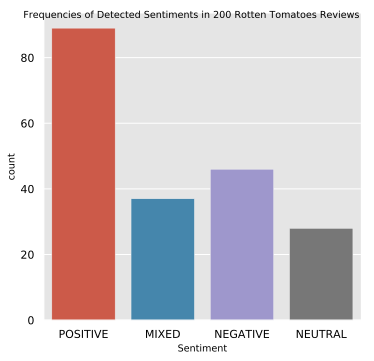

In [260]:
rating_sent = sb.catplot(x="Sentiment", kind= "count", data=rotten_critics2) 
rating_sent.fig.suptitle('Frequencies of Detected Sentiments in 200 Rotten Tomatoes Reviews')
#the majority of films have positive ratings
#from critic reviews dataset

We start with a barplot from the rotten_critics data, which contains 200 individual critic reviews. We find that an overwhelming majority of the reviews are detected as positive by comprehend. This is interesting because the common perception of a movie critic is hard to please.

Text(0,0.5,'Audience Score')

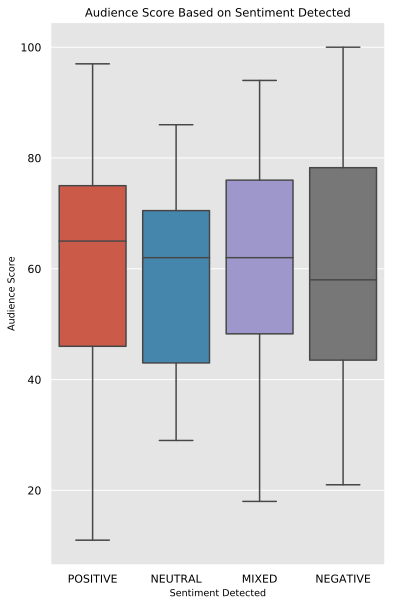

In [156]:
plot = sb.boxplot(x="Sentiment", y="audience_rating", data=rotten_consumer2)
plot.set_title('Audience Score Based on Sentiment Detected')
plot.set_xlabel('Sentiment Detected')
plot.set_ylabel('Audience Score')
#shows all sentiments were rated similarly by the audience - perhaps they don't know much?

This boxplot shows the relationship between how audiences rate a movie, and the detected sentiment of that movie's critic consensus. We see that there is not much difference between the scores from audiences and the sentiment detected in its critic consensus. This can be explained in one of two ways: either audiences are not knowledgable movie watchers, or comprehend detects all sentiments equally. Let's analyze more to find out.

Text(0,0.5,'Critic Score')

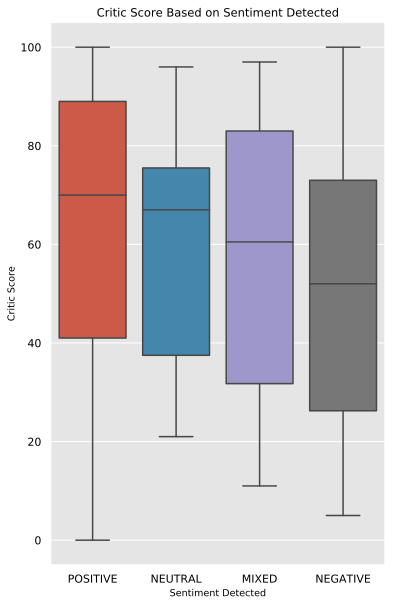

In [157]:
plot2 = sb.boxplot(x="Sentiment", y="tomatometer_rating", data=rotten_consumer2)
plot2.set_title('Critic Score Based on Sentiment Detected')
plot2.set_xlabel('Sentiment Detected')
plot2.set_ylabel('Critic Score')
#nice ladder - critic scores line up with amazon's detection

This plot offers the opposite of the previous plot. Scores given by critcs line up nicely with comprehend's detection of their consensus. This supports the idea that comprehend detects sentiments correctly, and that the earlier discrepency is due to lack of movie knowledge by audiences.

Text(0,0.5,'Number of Top Critics')

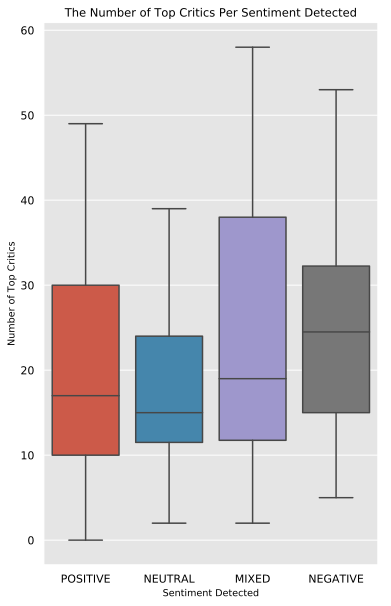

In [159]:
plot_topcritics = sb.boxplot(x="Sentiment", y="tomatometer_top_critics_count", data=rotten_consumer2)
plot_topcritics.set_title('The Number of Top Critics Per Sentiment Detected')
plot_topcritics.set_xlabel('Sentiment Detected')
plot_topcritics.set_ylabel('Number of Top Critics')
#shows that negative movies have more top critics reviewing them

Here, we see that movies with consensus detected as negative have a higher number of top critics reviewing these movies. This is likely because top critics are often the hardest to please, so movies who recieve more reviews from top critics will revieve harsher reviews.

In [160]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

Now let's import the libraries we will use for regression analysis.

In [173]:
rotten_consumer2.corr()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
runtime,1.000000,0.099557,0.157927,0.187447,0.030227,0.130461,0.223369,0.004329
tomatometer_rating,0.099557,1.000000,-0.166819,0.759734,-0.293520,-0.210884,0.393934,-0.685378
tomatometer_count,0.157927,-0.166819,1.000000,-0.075100,0.467489,0.920866,0.771418,0.726668
audience_rating,0.187447,0.759734,-0.075100,1.000000,-0.180376,-0.082885,0.341606,-0.485816
audience_count,0.030227,-0.293520,0.467489,-0.180376,1.000000,0.360524,0.171083,0.544381
tomatometer_top_critics_count,0.130461,-0.210884,0.920866,-0.082885,0.360524,1.000000,0.688335,0.692876
tomatometer_fresh_critics_count,0.223369,0.393934,0.771418,0.341606,0.171083,0.688335,1.000000,0.123416
tomatometer_rotten_critics_count,0.004329,-0.685378,0.726668,-0.485816,0.544381,0.692876,0.123416,1.000000


This table shows the correlations between variables of the rotten_consumer2 data. One important correlation to note is the weak correlation between the number of top critics that review a movie (tomatometer_top_critics_count) and the total audience of a movie (audience_count). This suggests that general movie goers do not attend or rate the same movies as top critics.

In [180]:
results_rotten_long=smf.ols('tomatometer_rating ~ Sentiment + tomatometer_fresh_critics_count + runtime + audience_count + tomatometer_top_critics_count ', data=rotten_consumer2).fit()
results_rotten_short=smf.ols('tomatometer_rating ~ Sentiment + tomatometer_top_critics_count', data=rotten_consumer2).fit()

We run two regressions. The first is a regression a movie's critics rating (or tomatometer rating) on detected sentiment, the number of critics who rate the movie "fresh", movie runtime, audience count, and the number of top critics who determine the movie's rating.

The second is a regression a movie's critics rating (or tomatometer rating) on detected sentiment and the number of top critics who determine the movie's rating.

In [179]:
results_rotten_long.params

Intercept                          68.967609
Sentiment[T.NEGATIVE]              -3.213500
Sentiment[T.NEUTRAL]                1.024929
Sentiment[T.POSITIVE]               1.038505
tomatometer_fresh_critics_count     0.745881
runtime                            -0.014674
audience_count                     -0.000019
tomatometer_top_critics_count      -1.722841
dtype: float64

Here we have the results of our first regression. The positive coefficient of positive sentiment and the negative coefficient on negative sentiment indicate that comprehend is correctly detecting sentiments. But variables such as runtime and audience count, which possibly could help explain a movie's rating, did not have strong coefficients, so we will remove them for the next regression.

In [182]:
results_rotten_short.params

Intercept                        67.182624
Sentiment[T.NEGATIVE]            -7.619047
Sentiment[T.NEUTRAL]             -1.719839
Sentiment[T.POSITIVE]             3.817204
tomatometer_top_critics_count    -0.402529
dtype: float64

After removing runtime and audience count, we have a see a stronger coefficient on detected sentiment, which backs up the previous hypothesis that comprehend was correctly detecting sentiment. Also, see a smaller, negtative coefficient on the number of top critics who rate the movie. This indicates that movies that are reviewed by more top critics often have lower ratings.

### Import Cornell Movies Data

Unlike the RT data, which contains a handful of reviews across a wide range of authors, the Cornell data contains a broad range of reviews for a small set of authors. Furthermore, the Cornell dataset only contains movie reviews but does not contain the title of the movie or any associated identifiers; therefore, validating the sentiment of the author's review compared to the overall reception of the movie or even the other authors in the dataset is not possible.

As per the Cornell movie reviews website, the "label_3class" and "label_4class" columns were derived by the following:


<pre>Label Decision 

The numerical ratings were derived from texts in the original html
files.  Note that with our particular conversion scheme, 0-to-4 stars
within a four star system translates into 0.1-to-0.9 in our normalized
numerical ratings, whereas 0-to-5 stars within a five star system
translates into 0-to-1.  (The reasoning was that in a four-star
system, an author is more likely to assign "endpoint" scores because
the dynamic range of the rating scheme is smaller.)
 
The class labels were then derived from the normalized numerical ratings.    
  * for the three-class task: 
  	0: rating <= 0.4
	1: 0.4 < rating < 0.7
	2: rating >= 0.7

  * for the four-class task: 
        0: rating <=.3
        1: .4 <= rating <=.5
	2: .6 <= rating <= .7
	3: .8 <= rating</pre>

The data in the Cornell Movies Dataset is provided in a selection of text files (e.g. review, rating, label) corresponding to individual columns in the final table, across different folders for each author. The below code scans the extracted file structure from the Cornell dataset and combines the text files together across all authors into a unified pandas DataFrame.

In [8]:
cornell_reviews = pd.DataFrame()

basedir = "/home/ec2-user/SageMaker/cornell/scaledata/"
cornell_critics = os.listdir(basedir)
for crit in cornell_critics:
    os.chdir
    rid = pd.read_csv(basedir+crit+"/"+"id."+crit,sep="\t",header=None)
    text = pd.read_csv(basedir+crit+"/"+"subj."+crit,sep="\t",header=None)
    rating = pd.read_csv(basedir+crit+"/"+"rating."+crit,sep="\t",header=None)
    three = pd.read_csv(basedir+crit+"/"+"label.3class."+crit,sep="\t",header=None)
    four = pd.read_csv(basedir+crit+"/"+"label.3class."+crit,sep="\t",header=None)
    df = pd.concat([rid,text,rating,three,four],axis=1)
    df.columns=["rating_id","review_content","review_score","review_label_3class","review_label_4class"]
    df["critic_name"] = crit
    cornell_reviews = pd.concat([cornell_reviews,df])

NameError: name 'pd' is not defined

Let's take a look at the final merged DataFrame:

In [9]:
display(cornell_reviews)
display(cornell_reviews.describe())

NameError: name 'cornell_reviews' is not defined

As you can see, the Cornell dataset contains 5,006 reviews and rating scores across four authors, with an average rating of 0.58 (slightly positive, e.g. 2.9 stars out of 5).

In [186]:
cornell1=cornell_reviews['review_content'][0:100]
cornell5=cornell_reviews['review_content'][400:500]
cornell8=cornell_reviews['review_content'][4900:5000]

For our analysis of the Cornell reviews dataset, we will investigate 100 movies with poor, medium, and good reviews. The new datasets cornell1, cornell5, and cornell8 extract only 'review_content', which is the movies review, from 100 poor, medium, and good reviews respectively.

In [188]:
cornell_reviews_poor=cornell_reviews[0:100]
cornell_reviews_med=cornell_reviews[400:499]
cornell_reviews_good=cornell_reviews[4900:4999]

We create three new datasets here that contain the same 100 poor, medium, and good reviews as above. These will be used later to add the detected sentiment back in as a new column, just as we did for the rotten tomatoes data.

In [189]:
sentiment_dict_cornell1 = {}
for movie1 in cornell1:
    try:
        sentiment_cornell1 = comprehend.detect_sentiment(Text=movie1, LanguageCode='en')
        sentiment_dict_cornell1[movie1] = sentiment_cornell1['Sentiment']
    except Exception:
        pass

Just like for rotten tomatoes, we run a for loop that extracts the detected sentiment for each (poor) review in cornell1. These are added to an empty dictionary sentiment_dict_cornell.

In [190]:
percieved_sentiments_cornell1=[]
for keys in sentiment_dict_cornell1.keys():
    percieved_sentiments_cornell1.append(sentiment_dict_cornell1[keys])

This extracts the key of our newly created dictionary, which in this case are the detected sentiments.

In [191]:
cornell_reviews_poor['Sentiment'] = percieved_sentiments_cornell1
cornell_reviews_poor.head()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,rating_id,review_content,review_score,review_label_3class,review_label_4class,critic_name,Sentiment
0,2321,i didn't expect ghost in the machine to be thi...,0.05,0,0,James+Berardinelli,NEGATIVE
1,3337,"admittedly , with a title like the mangler , y...",0.05,0,0,James+Berardinelli,MIXED
2,6511,"cast : christopher lambert , natasha henstridg...",0.05,0,0,James+Berardinelli,MIXED
3,6912,"inevitably , someone is going to ask me why i ...",0.05,0,0,James+Berardinelli,NEGATIVE
4,2240,ernest : the one-joke concept that refuses to ...,0.09,0,0,James+Berardinelli,NEGATIVE


Now we have created a new column with the detected sentiment of each review. We will now repeat this same process for cornell5, containing medium reviews, and cornell8, containing good reviews.

In [192]:
sentiment_dict_cornell5 = {}
for movie5 in cornell5:
    try:
        sentiment_cornell5 = comprehend.detect_sentiment(Text=movie5, LanguageCode='en')
        sentiment_dict_cornell5[movie5] = sentiment_cornell5['Sentiment']
    except Exception:
        pass

Filling our empty dictionary with detected sentiments.

In [193]:
percieved_sentiments_cornell5=[]
for keys5 in sentiment_dict_cornell5.keys():
    percieved_sentiments_cornell5.append(sentiment_dict_cornell5[keys5])

Extracting detected sentiments and placing them into a list.

In [195]:
cornell_reviews_med['Sentiment'] = percieved_sentiments_cornell5
cornell_reviews_med.head()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,rating_id,review_content,review_score,review_label_3class,review_label_4class,critic_name,Sentiment
400,3281,the commercials for in the mouth of madness re...,0.57,1,1,James+Berardinelli,MIXED
401,3711,given its position in the summer blockbuster r...,0.57,1,1,James+Berardinelli,NEUTRAL
402,3861,"cast : alicia silverstone , paul rudd , stacey...",0.57,1,1,James+Berardinelli,MIXED
403,3919,a general rule of summer film watching is to b...,0.57,1,1,James+Berardinelli,MIXED
404,4163,"she has succeeded , albeit perhaps * too * wel...",0.57,1,1,James+Berardinelli,MIXED


Now we have a new column for medium rated movies.

In [196]:
sentiment_dict_cornell8 = {}
for movie8 in cornell8:
    try:
        sentiment_cornell8 = comprehend.detect_sentiment(Text=movie8, LanguageCode='en')
        sentiment_dict_cornell8[movie8] = sentiment_cornell8['Sentiment']
    except Exception:
        pass

Running our trusted for loop one more time to place detected sentiments into an empty dictionary.

In [197]:
percieved_sentiments_cornell8=[]
for keys8 in sentiment_dict_cornell8.keys():
    percieved_sentiments_cornell8.append(sentiment_dict_cornell8[keys8])

Extracting the detected sentiment to place in an empty list.

In [198]:
cornell_reviews_good['Sentiment'] = percieved_sentiments_cornell8
cornell_reviews_good.head()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,rating_id,review_content,review_score,review_label_3class,review_label_4class,critic_name,Sentiment
796,2769,"starring : sihung lung , chien-lien wu , kuie-...",0.8,2,2,Scott+Renshaw,POSITIVE
797,2771,"starring : harrison ford , willem dafoe , joaq...",0.8,2,2,Scott+Renshaw,NEUTRAL
798,2895,"starring : phoebe cates , jim broadbent , wend...",0.8,2,2,Scott+Renshaw,MIXED
799,2955,screenplay : scott alexander and larry karasze...,0.8,2,2,Scott+Renshaw,NEGATIVE
800,3046,screenplay : woody allen and douglas mcgrath ....,0.8,2,2,Scott+Renshaw,NEUTRAL


Now we have added our final sentiment column for good reviews.

# Analysis of Cornell Movie Reviews
Let's begin with some plots.

Text(0.5,0.98,'Detected Sentiment Frequencies Across Poor Reviews')

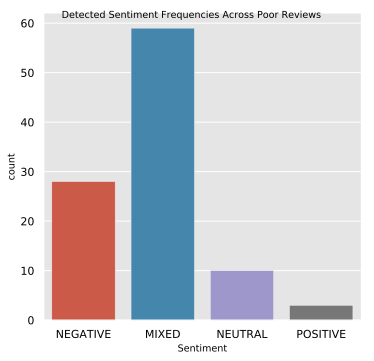

In [248]:
poor_plot = sb.catplot(x='Sentiment',kind = "count", data=cornell_reviews_poor)
poor_plot.fig.suptitle("Detected Sentiment Frequencies Across Poor Reviews")

Text(0.5,0.98,'Detected Sentiment Frequencies Across Neutral Reviews')

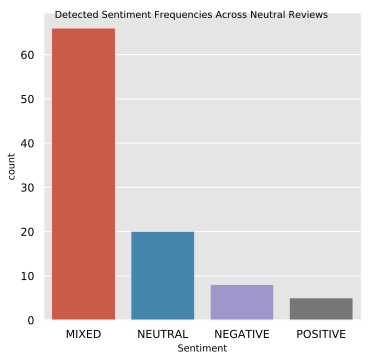

In [247]:
med_plot = sb.catplot(x='Sentiment',kind = "count", data=cornell_reviews_med)
med_plot.fig.suptitle("Detected Sentiment Frequencies Across Neutral Reviews")

Text(0.5,0.98,'Detected Sentiment Frequencies Across Positive Reviews')

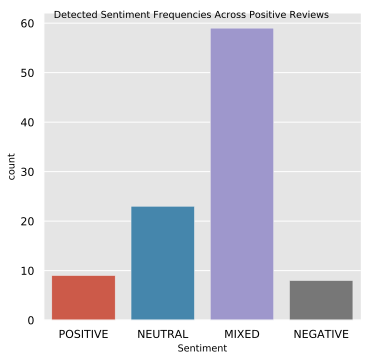

In [261]:
good_plot = sb.catplot(x='Sentiment',kind = "count", data=cornell_reviews_good)
good_plot.fig.suptitle('Detected Sentiment Frequencies Across Positive Reviews')

Looking at these three bar graphs, we see discrepencies in comprehend's ability to detect the sentiment of the Cornell reviews. In order, the bar graphs plot the frequency of each detected sentiment in poor, medium, and well rated movies. However, we only see the detected sentiment line up with the movie's rating in the middle graph, when mixed and neutral sentiments make up the vast majority. The first and third bar graphs have mixed sentiments making up the majority when it should be negative (in graph 1) and positive (in graph 3).
These discrepencies could be due to sympathy in movie reviews. If a reviewer did not like the movie, they would make this known to their reader, but would highlight some positives as well. Instead of only pointing out what the movie does poorly, human sympathy will take over, causing the reviewer to include what the movie does well. It is possible that comprehend does not interpret this correctly.

In [224]:
cornell_poor_reg = smf.ols('review_score ~ Sentiment', data=cornell_reviews_poor).fit()
cornell_med_reg = smf.ols('review_score ~ Sentiment', data=cornell_reviews_med).fit()
cornell_good_reg = smf.ols('review_score ~ Sentiment', data=cornell_reviews_good).fit()

To analyze the relationship between a movie's review score and the review's detected sentiment from the Cornell reviews data, we run three regressions. All three are regressions of the review score on detected sentiment, but use poor, medium, and good review data.

In [227]:
cornell_poor_reg.params

Intercept                0.242373
Sentiment[T.NEGATIVE]   -0.017730
Sentiment[T.NEUTRAL]     0.010627
Sentiment[T.POSITIVE]    0.047627
dtype: float64

The results of the first regression of review score on sentiment for the poor review data.

In [228]:
cornell_med_reg.params

Intercept                0.593788
Sentiment[T.NEGATIVE]    0.002462
Sentiment[T.NEUTRAL]     0.001212
Sentiment[T.POSITIVE]    0.006212
dtype: float64

The results of the second regression of review score on sentiment for the medium review data.

In [229]:
cornell_good_reg.params

Intercept                0.872881
Sentiment[T.NEGATIVE]   -0.010381
Sentiment[T.NEUTRAL]     0.022771
Sentiment[T.POSITIVE]    0.027119
dtype: float64

The results of the third regression of review score on sentiment for the good review data.

Looking at the results of all three regressions, we see only very small differences in coefficients within and across regressions. Using the third regression as an example, we would expect to see a larger coefficient on positive sentiment than any other coefficient, but this is not the case. The coefficient on positive sentiment is only slightly larger than that of neutral sentiment, suggesting that comprehend detects an equal amount of neutral and positive sentiments, when it should detect mostly positive.